In [60]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import hog
from skimage import exposure

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage import exposure
from skimage import color
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.measure import regionprops, find_contours
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from utils import *
from feature_util import *





In [61]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,suit
0,Dataset/train/ace of clubs/001.jpg,clubs
1,Dataset/train/ace of clubs/002.jpg,clubs
2,Dataset/train/ace of clubs/003.jpg,clubs
3,Dataset/train/ace of clubs/004.jpg,clubs
4,Dataset/train/ace of clubs/005.jpg,clubs


In [62]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


## Augment Images

In [63]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    #rescale = 1/255.0,   #Want 0 to 255 values for the color histogram
    rotation_range= 45,
    zoom_range= 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator() #rescale = 1/255.0) #want 0 to 255 values for the color histogram

# Create data generators for train, validation, and test
batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False
)

valid_generator = test_data_generator.flow_from_dataframe( #change this to use test_data_generator since don't want to augment the valid images
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False
)

test_generator = test_data_generator.flow_from_dataframe( #change this to use test_data_generator since don't want to augment the valid images
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False
)


Found 5138 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


### Hue

In [64]:

def hist_hue(image):
    
    # Convert the image from RGB to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Calculate histograms for each channel
    hist_hue = cv2.calcHist([image_hsv], [0], None , [255], [0, 256]).astype(np.uint8)

    #normalize 
    hist_hue_normalized = (hist_hue - np.min(hist_hue)) / (np.max(hist_hue)  - np.min(hist_hue) )
    
    # Scale the normalized histogram to have values between 0 and 255
    hist_hue_scaled = (hist_hue_normalized * 255).astype(np.uint8)
    
    return hist_hue_scaled

# Function to compute hsv features for a batch of images
def extract_hue_features_from_generator(data_generator):
    hsv_features = []
    labels = []
    num_batches = len(data_generator)
    
    for _ in range(num_batches):
        batch_images, class_labels = data_generator.next()  # Get the next batch of augmented images (ignoring the labels)
        
        # Compute hue features for each image in the batch
        for image, label in zip(batch_images,class_labels):
            hue_feature = hist_hue(image).flatten()  
            hsv_features.append(hue_feature)
            label = list(label)
            labels.append(label)
            
    return np.array(hsv_features),labels




In [65]:

train_hue_features, train_labels = extract_hue_features_from_generator(train_generator)
valid_hue_features, valid_labels = extract_hue_features_from_generator(valid_generator)
test_hue_features, test_labels = extract_hue_features_from_generator(test_generator)

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

<ipython-input-64-d33417abbb76>:10: RuntimeWarning: invalid value encountered in true_divide
  hist_hue_normalized = (hist_hue - np.min(hist_hue)) / (np.max(hist_hue)  - np.min(hist_hue) )


### LDA Classification

In [66]:
train_hue_features[25]

array([138, 150, 183, 246,   2,  94,  56, 253, 114,  92, 166, 247, 152,
        93,  30,  21,   5, 244,  14,  10,  50,  88, 149, 218, 245,  83,
        62,  14, 251, 242, 163, 159, 197, 181,  59, 246,  28, 209, 219,
       172,  36,  47,   1, 164,  98,  96,  92, 190, 156,  39, 116,  99,
        74,  56,  58, 111,  61,  45,  88, 150, 227, 198, 172, 211, 208,
       188, 209, 189,  19, 200, 255, 195, 114, 104, 109, 124, 116, 114,
       112,  96,  89, 101,  99,  99,  82,  89,  81,  74,  81,  69,  74,
        69,  65,  53,  35,  45,  40,  44,  45,  35,  39,  34,  43,  38,
        34,  34,  31,  39,  26,  36,  28,  24,  21,  22,  26,  21,  21,
        21,  18,  18,  10,  20,  12,  16,   9,  15,  12,   9,  18,  16,
        17,  15,  18,  15,  14,  19,  17,  13,  11,  16,  13,  10,  13,
         9,  12,  16,  10,   3,   8,   7,  10,   8,  14,   6,   7,  10,
        11,   5,  15,   9,  11,   9,  12,   9,   8,   2,   5,   3,  10,
         5,   6,   7,   7,   1,   4,   6,   3,   2,   5,   1,   

In [67]:
# Initialize and fit the LDA model
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(train_hue_features, train_generator.labels)

# Transform the validation features to the LDA space
valid_features_lda = lda_model.transform(valid_hue_features)

# Predict on the validation data
valid_predictions = lda_model.predict(valid_hue_features)


# Calculate the accuracy of the LDA model
accuracy = accuracy_score(valid_generator.labels,valid_predictions)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.3961089494163424


In [68]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(valid_generator.labels, valid_predictions)
print("Validation Classification Report:\n", valid_report)


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.21      0.28       310
           1       0.35      0.25      0.29       313
           2       0.36      0.53      0.43       316
           3       0.46      0.57      0.51       346

    accuracy                           0.40      1285
   macro avg       0.39      0.39      0.38      1285
weighted avg       0.39      0.40      0.38      1285



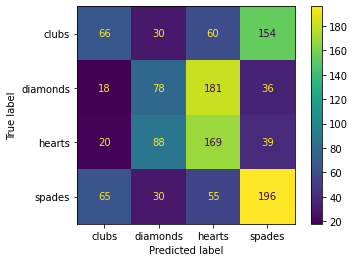

In [69]:
confusion = confusion_matrix(valid_generator.labels,valid_predictions)
disp = ConfusionMatrixDisplay(confusion,display_labels = class_names)
disp.plot()

### Grid search LDA: 

In [70]:
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],  # Different solver options for LDA
    'shrinkage': [None, 'auto', 0.1, 0.5],  # Shrinkage parameter (None means no shrinkage)
}

# Initialize the GridSearchCV with the LDA model and parameter grid
grid_search = GridSearchCV(lda_model, param_grid, cv=5)

# Fit the GridSearchCV on the training data
grid_search.fit(train_hue_features, train_generator.labels)

# Get the best LDA model from the grid search
best_lda_model = grid_search.best_estimator_

# Predict on the validation data using the best model
valid_predictions = best_lda_model.predict(valid_hue_features)

# Calculate the accuracy of the best LDA model
accuracy = accuracy_score(valid_generator.labels, valid_predictions)
print("Validation Accuracy with LDA:", accuracy)

# Print the best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

/Users/caseyhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/caseyhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caseyhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py", line 547, in fit
    raise NotImplementedError('shrinkage not supported')
NotImplementedError: shrinkage not supported

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/caseyhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent

/Users/caseyhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.39548911 0.39568366 0.39568366        nan 0.394709   0.394709
        nan 0.39801394 0.39801394        nan 0.40073919 0.40073919]
  warnings.warn(


Validation Accuracy with LDA: 0.3961089494163424
Best Hyperparameters: {'shrinkage': None, 'solver': 'svd'}
